In [1]:
import warnings

import arviz as az
import numpy as np
import pandas as pd
import xarray as xr

import bambi as bmb

bmb.config["INTERPRET_VERBOSE"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
fish_data = pd.read_stata("http://www.stata-press.com/data/r11/fish.dta")
cols = ["count", "livebait", "camper", "persons", "child"]
fish_data = fish_data[cols]
fish_data["child"] = fish_data["child"].astype(np.int8)
fish_data["persons"] = fish_data["persons"].astype(np.int8)
fish_data["livebait"] = pd.Categorical(fish_data["livebait"])
fish_data["camper"] = pd.Categorical(fish_data["camper"])

In [3]:
fish_model = bmb.Model(
    "count ~ livebait + camper + persons + child", 
    fish_data, 
    family='zero_inflated_poisson'
)

fish_idata = fish_model.fit(chains=4, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [count_psi, Intercept, livebait, camper, persons, child]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


## Advanced usage

In [4]:
from bambi.interpret.helpers import data_grid, select_draws

### Create your own data

In [5]:
conditional = {
    "camper": np.array([0, 1]),
    "persons": np.arange(0, 5, 1),
}
variable = {"livebait": np.array([0, 1])}

In [6]:
new_data = data_grid(fish_model, conditional, variable)
new_data

,camper,persons,livebait,child
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,1,1,0
4,0,2,0,0
5,0,2,1,0
6,0,3,0,0
7,0,3,1,0
8,0,4,0,0
9,0,4,1,0


### Compute comparisons

In [11]:
idata_new = fish_model.predict(fish_idata, data=new_data, inplace=False)

In [12]:
idata_new

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [13]:
draw_1 = select_draws(idata_new, new_data, {"livebait": 0}, "count_mean")
draw_2 = select_draws(idata_new, new_data, {"livebait": 1}, "count_mean")

(draw_2 - draw_1).mean(("chain", "draw"))

<xarray.DataArray 'count_mean' (count_obs: 10)>
array([ 0.36152577,  0.86348116,  2.06643138,  4.95503272, 11.90508543,
        0.7086581 ,  1.69256968,  4.05050846,  9.71244674, 23.33495469])
Coordinates:
  * count_obs  (count_obs) int64 0 1 2 3 4 5 6 7 8 9

We can compare this comparison with `bmb.interpret.comparisons`.

In [15]:
summary_df =bmb.interpret.comparisons(
    fish_model,
    fish_idata,
    contrast={"livebait": [0, 1]},
    conditional=conditional
)
summary_df

,term,estimate_type,value,camper,persons,child,estimate,lower_3.0%,upper_97.0%
0,livebait,diff,"(0, 1)",0,0,0,0.361526,0.232076,0.478699
1,livebait,diff,"(0, 1)",0,1,0,0.863481,0.614187,1.094623
2,livebait,diff,"(0, 1)",0,2,0,2.066431,1.567933,2.531342
3,livebait,diff,"(0, 1)",0,3,0,4.955033,3.971103,6.004960
4,livebait,diff,"(0, 1)",0,4,0,11.905085,9.586727,14.514207
5,livebait,diff,"(0, 1)",1,0,0,0.708658,0.498476,0.939042
6,livebait,diff,"(0, 1)",1,1,0,1.692570,1.273824,2.088714
7,livebait,diff,"(0, 1)",1,2,0,4.050508,3.329138,4.769666
8,livebait,diff,"(0, 1)",1,3,0,9.712447,8.400628,11.041247
9,livebait,diff,"(0, 1)",1,4,0,23.334955,19.752432,26.467248


### Cross comparisons

Comparing between contrasts and levels (if `conditional` values are categorical).

The `np.where` function below returns a boolean array 

In [16]:
cond_11 = {
    "camper": 0,
    "persons": 1,
    "child": 0,
    "livebait": 0 
}

cond_14 = {
    "camper": 0,
    "persons": 4,
    "child": 0,
    "livebait": 0
}

draws_11 = select_draws(idata_new, new_data, cond_11, "count_mean")
draws_14 = select_draws(idata_new, new_data, cond_14, "count_mean")

In [18]:
cond_21 = {
    "camper": 0,
    "persons": 1,
    "child": 0,
    "livebait": 1
}

cond_24 = {
    "camper": 0,
    "persons": 4,
    "child": 0,
    "livebait": 1
}

draws_21 = select_draws(idata_new, new_data, cond_21, "count_mean")
draws_24 = select_draws(idata_new, new_data, cond_24, "count_mean")

After computing the "first level" comparison (`diff_1` and `diff_2`) we can compute the difference between these two differences to obtain a _cross-comparison_. The cross-comparison is useful for when we want to know what happens when two (or more) predictors change at the same time.

In [19]:
diff_1 = (draws_14 - draws_11)
diff_2 = (draws_24 - draws_21)

cross_comparison = (diff_2 - diff_1).mean(("chain", "draw"))
cross_comparison

<xarray.DataArray 'count_mean' (count_obs: 1)>
array([11.04160427])
Coordinates:
  * count_obs  (count_obs) int64 0

In [4]:
data = pd.read_csv("/Users/gabestechschulte/downloads/simulated_data_comparisons.csv")
data

,correct,count,individual,factor1,factor2,factor3
0,204,576,18,A,X,1
1,201,576,19,A,X,1
2,157,576,20,A,X,1
3,209,576,21,A,X,1
4,169,576,22,A,X,1
...,...,...,...,...,...,...
103,220,720,4,C,Y,2
104,253,720,5,C,Y,2
105,199,720,6,C,Y,2
106,223,720,7,C,Y,2


In [15]:
priors = {
    "factor3:factor2": bmb.Prior("Normal", mu=0, sigma=1),
    "factor1": bmb.Prior("Normal", mu=0, sigma=1),
    "factor3:factor2|individual": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Gamma", alpha=3, beta=3))
}

model = bmb.Model(
    "p(correct, count) ~ 0 + factor3:factor2 + factor1  + (0 + factor3:factor2 | individual)",
    data,
    family="binomial",
    categorical=["factor3", "individual", "factor1", "factor2"],
    priors=priors,
    noncentered=False)

idata = model.fit(tune=2000, draws=2000, random_seed=123, init='adapt_diag',
                  target_accept=0.9, idata_kwargs={'log_likelihood':True})

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [factor3:factor2, factor1, factor3:factor2|individual_sigma, factor3:factor2|individual]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 13 seconds.


In [111]:
model.data.shape

(108, 7)

In [134]:
data['report frequency (%)'] = data['correct'] / data['count']

df, idata_new = bmb.interpret.comparisons(
        model=model, 
        idata=idata, 
        average_by=['factor3', 'factor1'],
        contrast={"factor2": ["X", "Y"]},
        conditional=None
)

In [132]:
def select_draws(idata, condition_idx):
    draws = idata.posterior.sel({"p(correct, count)_obs": condition_idx})["p(correct, count)_mean"]
    draws = draws.assign_coords({"p(correct, count)_obs": np.arange(len(condition_idx))})   
    return draws 

In [136]:
xr_df = xr.Dataset.from_dataframe(df)

del idata_new.observed_data
idata_new.add_groups(data=xr_df)
idata_new.data = idata_new.data.rename({"index": "p(correct, count)_obs"})

In [139]:
idx_11 = np.where((idata_new.data.factor2 == "Y") & (idata_new.data.factor1 == "A") & (idata_new.data.factor3 == 1))[0]
idx_41 = np.where((idata_new.data.factor2 == "X") & (idata_new.data.factor1 == "A") & (idata_new.data.factor3 == 1))[0]

draws_1 = select_draws(idata_new, idx_11)
draws_4 = select_draws(idata_new, idx_41)

diff = (draws_4 - draws_1).mean(("chain", "draw")) 
diff

<xarray.DataArray 'p(correct, count)_mean' (p(correct, count)_obs: 9)>
array([-0.06916495, -0.01116337, -0.02804197,  0.05374482, -0.0111794 ,
       -0.03263381,  0.12427712,  0.00411664, -0.14243505])
Coordinates:
  * p(correct, count)_obs  (p(correct, count)_obs) int64 0 1 2 3 4 5 6 7 8

In [173]:
range(10, 2)

range(10, 2)

In [181]:
df.iloc[idx_11].iloc[[0, 2, 4, 6, 8]]

,factor1,factor3,individual,factor2
54,A,1,18,Y
56,A,1,20,Y
58,A,1,22,Y
60,A,1,24,Y
62,A,1,26,Y


In [176]:
df.iloc[idx_41].iloc[[0, 2, 4, 6, 8]]

,factor1,factor3,individual,factor2
0,A,1,18,X
2,A,1,20,X
4,A,1,22,X
6,A,1,24,X
8,A,1,26,X


In [178]:
diff = (draws_4 - draws_1).sel({"p(correct, count)_obs": range(0, 10, 2)}).mean("p(correct, count)_obs")

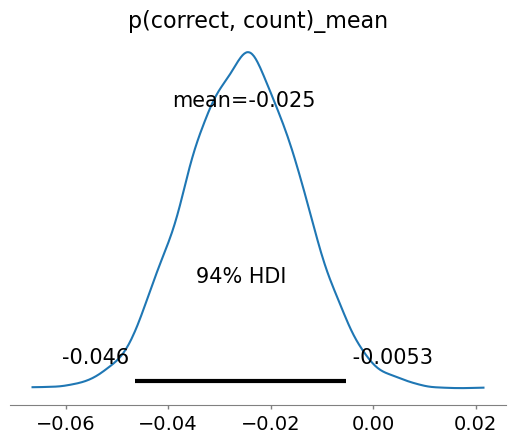

In [179]:
import arviz as az
az.plot_posterior(diff);

In [160]:
summary_df = bmb.interpret.comparisons(
        model=model, 
        idata=idata, 
        average_by=['factor3', 'factor1'],
        contrast={"factor2": ["X", "Y"]},
        conditional=None
)

In [161]:
summary_df

,term,estimate_type,value,factor3,factor1,estimate,lower_3.0%,upper_97.0%
0,factor2,diff,"(X, Y)",1,A,0.012498,-0.033609,0.059407
1,factor2,diff,"(X, Y)",1,B,-0.007074,-0.054343,0.039211
2,factor2,diff,"(X, Y)",1,C,-0.018147,-0.061406,0.024466
3,factor2,diff,"(X, Y)",2,A,0.009130,-0.040111,0.058638
4,factor2,diff,"(X, Y)",2,B,-0.001638,-0.052208,0.048571
5,factor2,diff,"(X, Y)",2,C,-0.013849,-0.062257,0.033584
